Use AAA algorithm on f(x)=exp(x) in [-2,2]
一、初始化
二、主要迴圈 — 每次選一個新的支撐點
Step 1. 選取新的支撐點
Step 2. 建立 Loewner 矩陣
Step 3. SVD 分解求最小奇異向量
Step 4. 用權重𝑤計算新的有理函數近似
Step 5. 檢查誤差是否收斂
三、最後構造 callable 函數
這讓使用者可以輸入任意點𝑧_𝑞來評估近似值 r(zq)。

nr support points: → 選了幾個支撐點（越多表示函數越難近似）。
errvec → 每次迭代後誤差的變化，通常會快速下降。
圖上紅線 (AAA approximation) 幾乎重疊黑線 (exp)，表示近似很準。

nr support points: 7
errvec (last 5): [9.27565902e-03 8.05973263e-05 2.12193839e-07 8.06773759e-10
 1.34056655e-12]


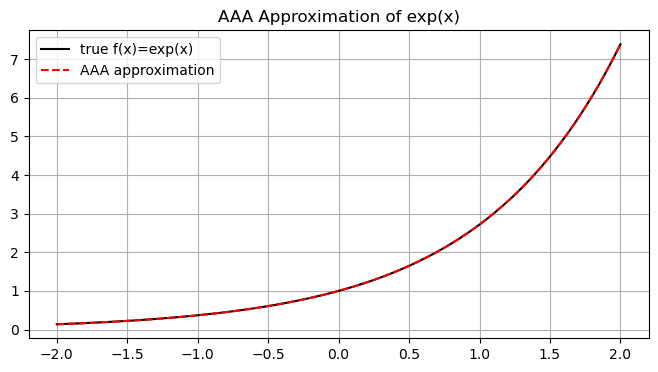

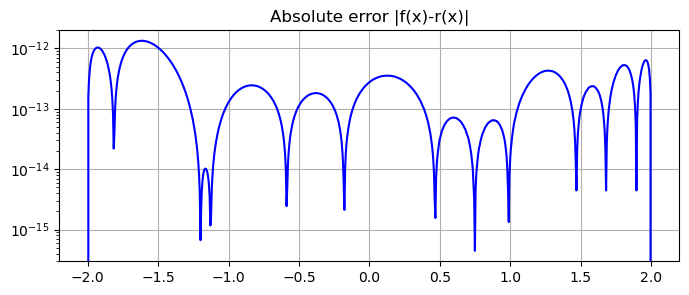

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def aaa(Z, F, tol=1e-12, mmax=50):
    """
    Stable AAA implementation:
      - Uses direct Loewner entries A_ij = (F_i - f_j) / (Z_i - z_j)
      - Defensive nan/inf handling and small regularization fallback
    Inputs:
      Z : 1D array of sample points (real or complex)
      F : 1D array of function values f(Z)
    Returns:
      dict with 'r' (callable), 'z' (support points), 'f' (values), 'w' (weights), 'errvec'
    """
    Z = np.asarray(Z, dtype=np.complex128)
    F = np.asarray(F, dtype=np.complex128)
    M = len(Z)
    if M == 0 or len(F) != M:
        raise ValueError("Z and F must be same non-empty length")
    # initial approx = constant mean
    R = np.full_like(F, np.mean(F, dtype=np.complex128))
    unused = np.arange(M)               # indices not chosen as support
    z = []  # support points
    f = []  # support values
    w = None
    errvec = []

    for m in range(1, min(mmax, M//2) + 1):
        # 1) choose next support point = argmax |F-R|
        j = int(np.argmax(np.abs(F - R)))
        z.append(Z[j])
        f.append(F[j])
        # update unused indices
        unused = unused[unused != j]

        zj = np.array(z, dtype=np.complex128)   # shape (m,)
        fj = np.array(f, dtype=np.complex128)   # shape (m,)

        # 2) build Cauchy-like matrix C (M x m) if needed, but for Loewner compute only rows 'unused'
        # Loewner entries for rows in 'unused': A_un[k, j] = (F[unused[k]] - fj[j]) / (Z[unused[k]] - zj[j])
        Zu = Z[unused][:, None]    # (Mu,1)
        Fu = F[unused][:, None]    # (Mu,1)
        Zj = zj[None, :]           # (1,m)
        Fj = fj[None, :]           # (1,m)
        # A_un shape (Mu, m)
        A_un = (Fu - Fj) / (Zu - Zj)
        # defensive cleanup
        A_un = np.nan_to_num(A_un, nan=0.0, posinf=0.0, neginf=0.0)

        # 3) SVD on A_un to get minimal singular vector (right singular vector)
        try:
            U, s, Vh = np.linalg.svd(A_un, full_matrices=False)
        except np.linalg.LinAlgError:
            # small regularization fallback
            # if A_un is nearly square, add small diag to stabilize
            eps = 1e-16
            Mu, mm = A_un.shape
            reg = eps * np.eye(Mu, mm) if Mu == mm else eps * np.eye(Mu, mm)[:Mu, :mm]
            A_reg = A_un + reg
            U, s, Vh = np.linalg.svd(A_reg, full_matrices=False)

        w = Vh.conj().T[:, -1]   # (m,) right singular vector for smallest singular value

        # 4) evaluate numerator and denominator at ALL sample points
        # Build full C (M x m) = 1/(Z_i - z_j)
        C = 1.0 / (Z[:, None] - zj[None, :])
        # defensive: fix any inf/nan if Z coincides with a support point; we will overwrite those exact indices later
        C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)

        N = C @ (w * fj)   # vector length M
        D = C @ w
        # To avoid dividing by exact zeros due to numerical cancellation, regularize small D entries
        small = np.abs(D) < 1e-20
        if np.any(small):
            D[small] = D[small] + 1e-20

        R_new = N / D
        # enforce interpolation at support points exactly:
        for jj, sv in enumerate(z):
            # find indices in Z exactly (or within tolerance) equal to sv
            idx = np.where(np.isclose(Z, sv))[0]
            if idx.size > 0:
                R_new[idx] = f[jj]

        # compute error and store
        err = np.max(np.abs(F - R_new))
        errvec.append(err)
        R = R_new

        # stopping
        if err <= tol * np.max(np.abs(F)):
            break

    # final callable approximant (works for scalars and vectors)
    def r_eval(zq):
        scalar_input = False
        zq_arr = np.asarray(zq, dtype=np.complex128)
        if zq_arr.shape == ():
            zq_arr = zq_arr[None]  # make 1D
            scalar_input = True
        Cq = 1.0 / (zq_arr[:, None] - np.array(z, dtype=np.complex128)[None, :])
        Cq = np.nan_to_num(Cq, nan=0.0, posinf=0.0, neginf=0.0)
        num = Cq @ (w * np.array(f, dtype=np.complex128))
        den = Cq @ w
        # avoid tiny denominator
        den[np.abs(den) < 1e-20] = den[np.abs(den) < 1e-20] + 1e-20
        out = num / den
        # enforce interpolation
        for jj, sv in enumerate(z):
            mask = np.isclose(zq_arr, sv)
            if np.any(mask):
                out[mask] = f[jj]
        out = np.real_if_close(out)
        return out[0] if scalar_input else out

    return {"r": r_eval, "z": np.array(z, dtype=np.complex128),
            "f": np.array(f, dtype=np.complex128), "w": w, "errvec": np.array(errvec)}

# --------------------------
# Test with a smooth function (exp)
# --------------------------
Z = np.linspace(-2, 2, 400)
F = np.exp(Z)
res = aaa(Z, F, tol=1e-12, mmax=80)
r = res['r']
print("nr support points:", len(res['z']))
print("errvec (last 5):", res['errvec'][-5:])

# Plot function and approximation
x_plot = np.linspace(-2, 2, 800)
plt.figure(figsize=(8,4))
plt.plot(x_plot, np.exp(x_plot), 'k-', label='true f(x)=exp(x)')
plt.plot(x_plot, r(x_plot), 'r--', label='AAA approximation')
plt.legend(); plt.grid(True); plt.title('AAA Approximation of exp(x)')
plt.show()

# Plot error
err_vals = np.abs(np.exp(x_plot) - r(x_plot))
plt.figure(figsize=(8,3))
plt.semilogy(x_plot, err_vals, 'b')
plt.title('Absolute error |f(x)-r(x)|')
plt.grid(True)
plt.show()